<a href="https://colab.research.google.com/github/abm018/Hydroponics/blob/main/Lettuce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import cv2
import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization, RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


# Load google drive to fetch the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists


In [ ]:
!ls /mydrive/lettuce/

Healthy  KDeficiency  NDeficiency  PDeficiency


# Define path to main folder and subfolders

In [ ]:
dataset_dir = '/mydrive/lettuce'
healthy_dir ='/mydrive/lettuce/Healthy'
n_def_dir = '/mydrive/lettuce/PDeficiency'
p_def_dir = '/mydrive/lettuce/P_Deficiency'
k_def_dir = '/mydrive/lettuce/KDeficiency'

# Load random data from dataset to check if defined path is correct or not

In [ ]:
def load_random_imgs_from_folder(folder):
  plt.figure(figsize=(20,20))
  for i in range(5):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.xlabel(f'Image Shape: {img.shape}')
    plt.imshow(img)

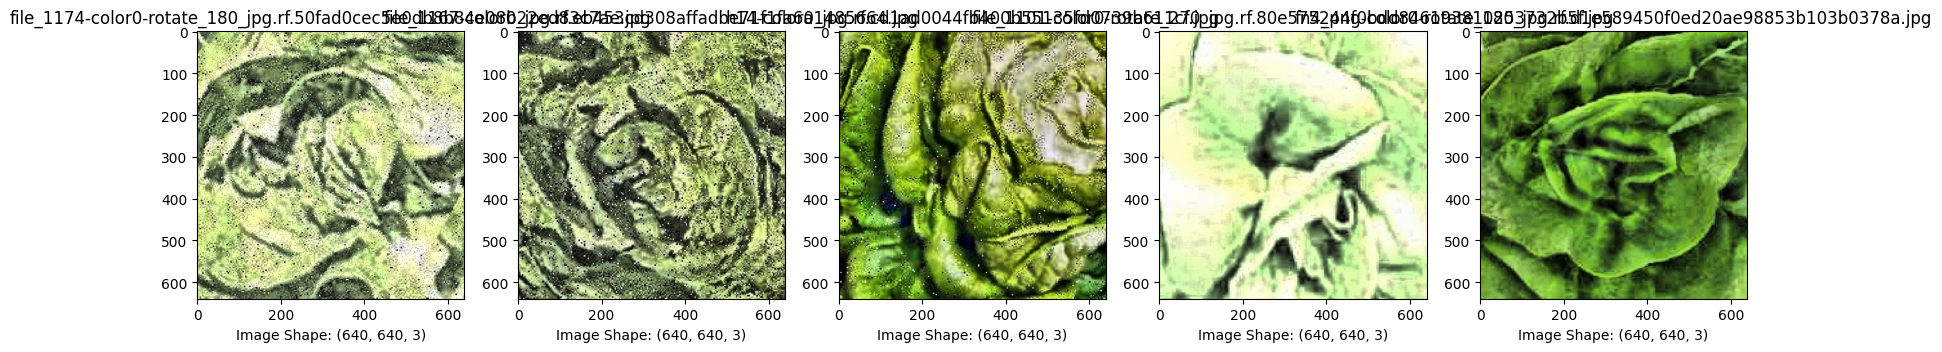

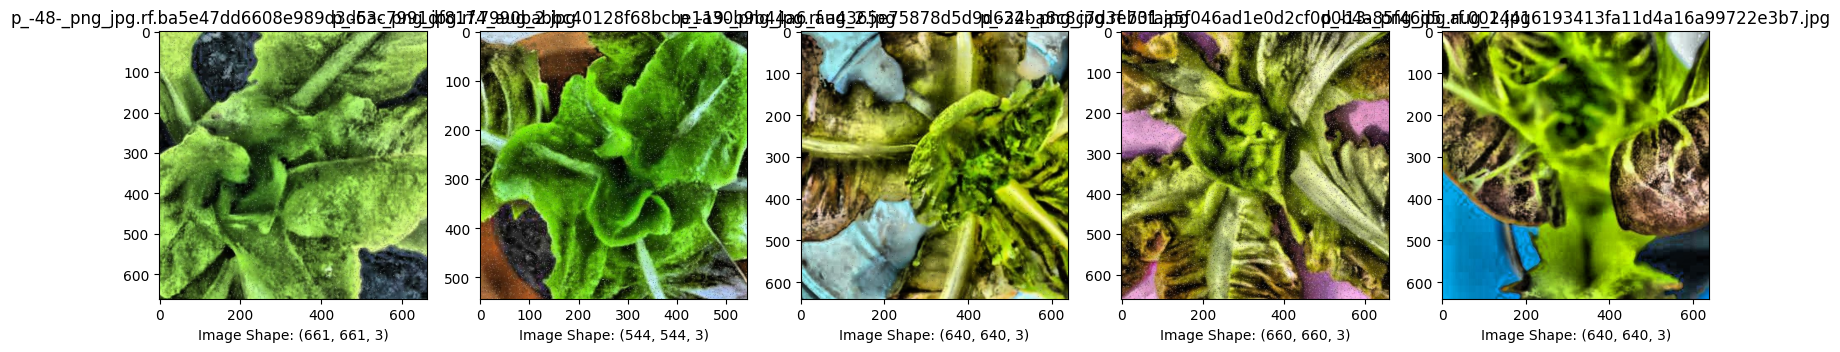

In [ ]:
load_random_imgs_from_folder(healthy_dir)
print('\n\n')
load_random_imgs_from_folder(n_def_dir)

# Create a dataframe

In [ ]:
labels=[]
for i in os.listdir(dataset_dir):
  labels+=[i]

print(labels)

['NDeficiency', 'KDeficiency', 'Healthy', 'PDeficiency']


In [ ]:
IMG_SIZE = 224 #constant declaration

# Image pre-processing and organizing the data to corresponding labels

In [ ]:
# img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
              if img[-3:] != 'txt':
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)



In [ ]:
dataset = get_data(dataset_dir)
np.random.shuffle(dataset)

In [ ]:
len(dataset)

4000

# Split the data for training, testing and validating

In [ ]:
train = dataset[:2800]
val = dataset[2800:3400]
test = dataset[3400:]

In [ ]:
train_df = pd.DataFrame(train,columns=['Feature','Label'])

# Plotting the frequency of data

In [ ]:
l=[]
for i in train_df['Label']:
  l.append(labels[i])

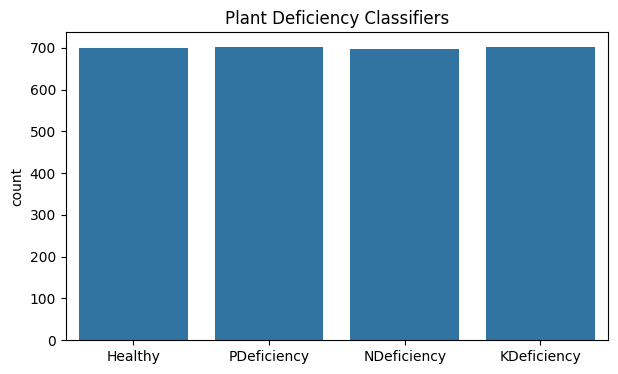

In [ ]:
plt.figure(figsize=(7,4))
sns.countplot(x=l);
plt.title('Plant Deficiency Classifiers');

# Extracting features and labels from train, test and validate

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [ ]:
np.array(x_train).max()

255

# Checking whether the classification went well

Text(0.5, 1.0, 'Healthy')

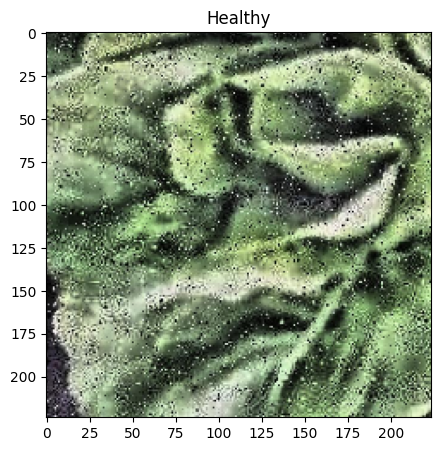

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

# Normalisation of dataset

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)


In [ ]:
x_test = np.array(x_test) / 255.0
y_test = np.array(y_test)

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((2800, 224, 224, 3),
 (2800,),
 (600, 224, 224, 3),
 (600,),
 (600, 224, 224, 3),
 (600,))

In [ ]:
type(y_train[0])

numpy.int64

# Visualizing some images and its labels

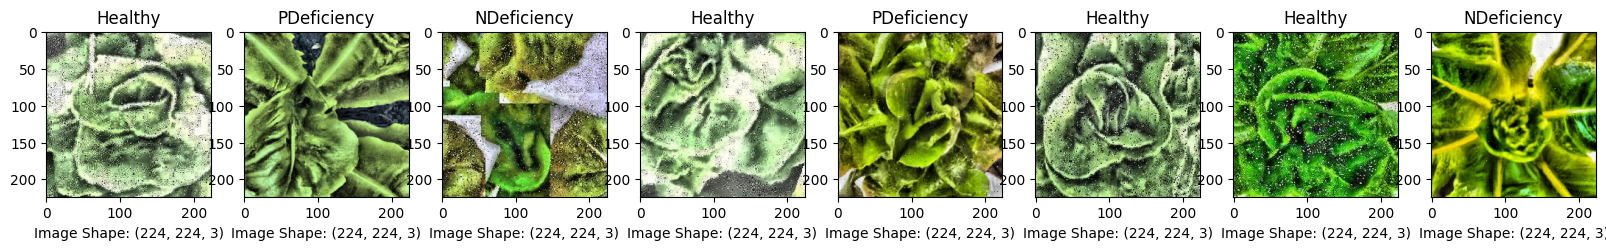

In [ ]:
plt.figure(figsize=(20,20))

for i in range(8):
  img = x_train[i]
  ax=plt.subplot(1,8,i+1)
  ax.title.set_text(labels[y_train[i]])
  plt.xlabel(f'Image Shape: {img.shape}')
  plt.imshow(img)


#Comparison between original and filtered image based on defined filters

In [ ]:
def plot_before_after(img, filtered_img):
  plt.figure(figsize=(10,10))
  plt.subplot(121),plt.imshow(img),plt.title('Original')
  plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(filtered_img),plt.title('Filtered')
  plt.xticks([]), plt.yticks([])
  plt.show()


In [ ]:
# for noise reduction
class Filters:
  def __init__(self, x_train):
    self.x_train = x_train

  def Gaussian_Blurr(self, kernel):
    self.kernel = kernel
    gauss_blurr = []
    for i in range(len(self.x_train)-1):
      f_img = cv2.GaussianBlur(self.x_train[i], self.kernel,0)
      gauss_blurr.append(f_img)
    return gauss_blurr

  def Median_Blurr(self, K):
    self.K = K
    median_blurr = []
    for i in range(len(self.x_train)-1):
      img = self.x_train[i].astype('float32') / 255.0
      f_img = cv2.medianBlur(img, self.K)
      median_blurr.append(f_img)
    return median_blurr

  def Bilateral_Blurr(self, diameter, sigmaColor, sigmaSpace):
    self.d = diameter
    self.sc = sigmaColor
    self.ss = sigmaSpace
    bilateral_blurr = []
    for i in range(len(self.x_train)-1):
      img = self.x_train[i].astype('float32') / 255.0
      f_img = cv2.bilateralFilter(img, self.d, self.sc, self.ss)
      bilateral_blurr.append(f_img)
    return bilateral_blurr

In [ ]:
img_filter = Filters(x_train)

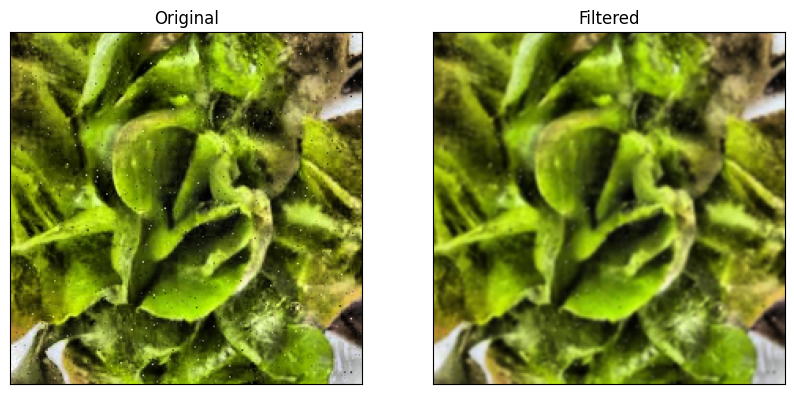

In [ ]:
gauss_imgs = img_filter.Gaussian_Blurr((3,3))
plot_before_after(x_train[4], gauss_imgs[4])

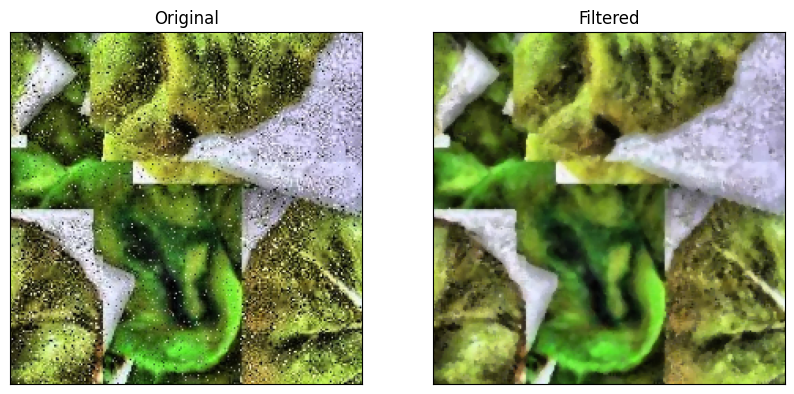

In [ ]:
medians = img_filter.Median_Blurr(3)
plot_before_after(x_train[2], medians[2])

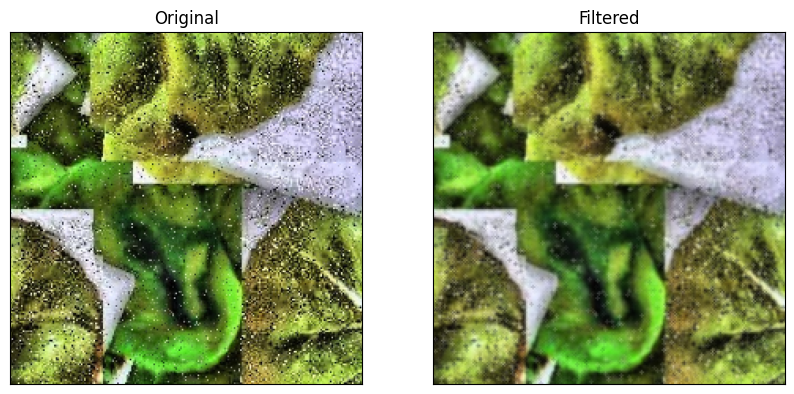

In [ ]:
bilateral_imgs = img_filter.Bilateral_Blurr(3, 11, 5)
plot_before_after(x_train[2], bilateral_imgs[2])

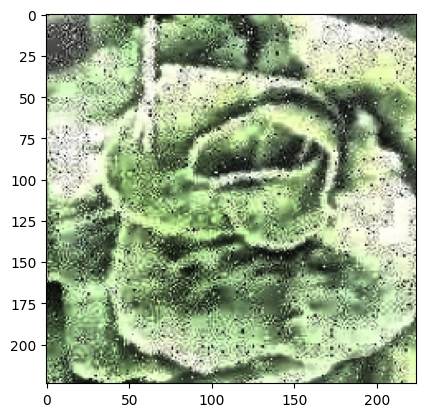

In [ ]:
plt.imshow(x_train[0])

In [ ]:
x_train[0].shape

(224, 224, 3)

#Normalization, data augmentation

In [ ]:
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

In [ ]:
# prepare an iterators to scale images
train_iterator_1 = train_datagen.flow(x_train, y_train, batch_size=64)
val_iterator_1 = val_datagen.flow(x_val, y_val, batch_size=64)
print('Batches train=%d, test=%d' % (len(train_iterator_1), len(val_iterator_1)))


Batches train=44, test=10


In [ ]:

# confirm the scaling works
batchX, batchy = train_iterator_1.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


Batch shape=(64, 224, 224, 3), min=0.000, max=1.000


#Defining various representations for performance analysis

In [ ]:
def learning_curve(model_fit, key='accuracy', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
def confusion_matrix_plot(matrix, model):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(labels);
    ax.yaxis.set_ticklabels(labels);
#     plt.savefig(f'CM_{model}.png', dpi=300)
    plt.show()


In [ ]:
def cal_score(model, key):

        # evaluate the model
    _, train_acc = model.evaluate(x_train/255.0, y_train, verbose=0)
    _, test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, val_acc = model.evaluate(x_val/255.0, y_val, verbose=0)


    print('Train: %.3f, Test: %.3f, Val: %.3f' % (train_acc, test_acc, val_acc))

    # predict probabilities for test set
    yprobs = model.predict(x_test, verbose=0)
    # predict crisp classes for test set
    yclasses = np.argmax(yprobs,axis=1)


    test_kappa = cohen_kappa_score(y_test, yclasses)
    print('Test Cohens kappa: %f' % test_kappa)
    print('\n')
    # confusion matrix
    matrix = confusion_matrix(y_test, yclasses)
    print(matrix)
    print('\n')

    f1 = f1_score(y_test, yclasses, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')

    print(classification_report(y_test, yclasses, target_names=labels))

    if key==1:
        confusion_matrix_plot(matrix, model)

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
             ModelCheckpoint(filepath='weights/inc_best2.h5', save_best_only=True)]

#Importing InceptionV3 for classfication

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
base_model = InceptionV3(input_shape = (IMG_SIZE, IMG_SIZE, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

#Defining neural network and training

In [ ]:


# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation


x = Dense(32, activation='relu')(x)
# Add a dropout rate of 0.2
x = Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = Dense(4, activation='softmax')(x)

inc_model9 = Model(base_model.input, x)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=800, decay_rate=0.6)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

inc_model9.compile(optimizer = optimizer,
                   loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   metrics = ['accuracy'])

In [ ]:
inc_hist = inc_model9.fit_generator(train_iterator_1,epochs=20,verbose=1,validation_data=val_iterator_1, callbacks = callbacks)

#Performance analysis

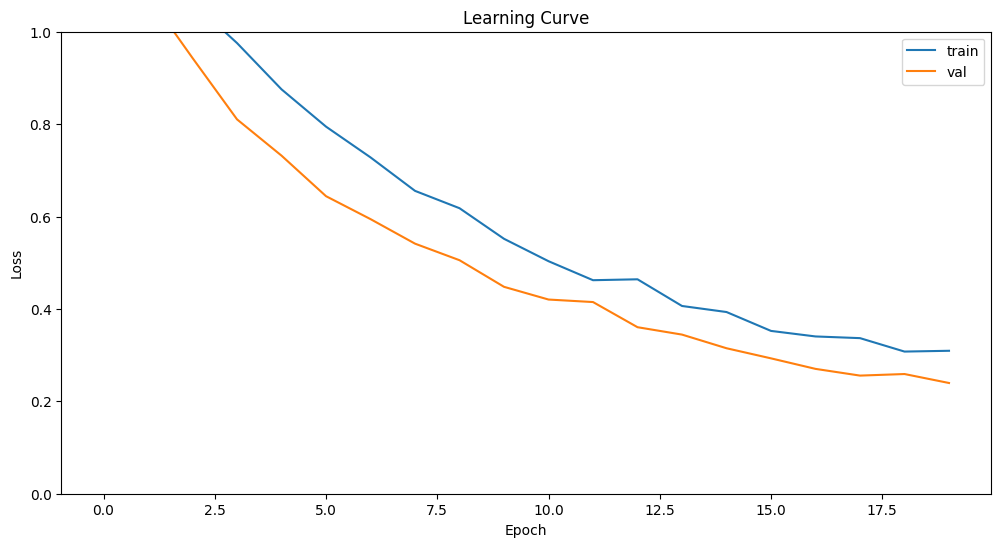

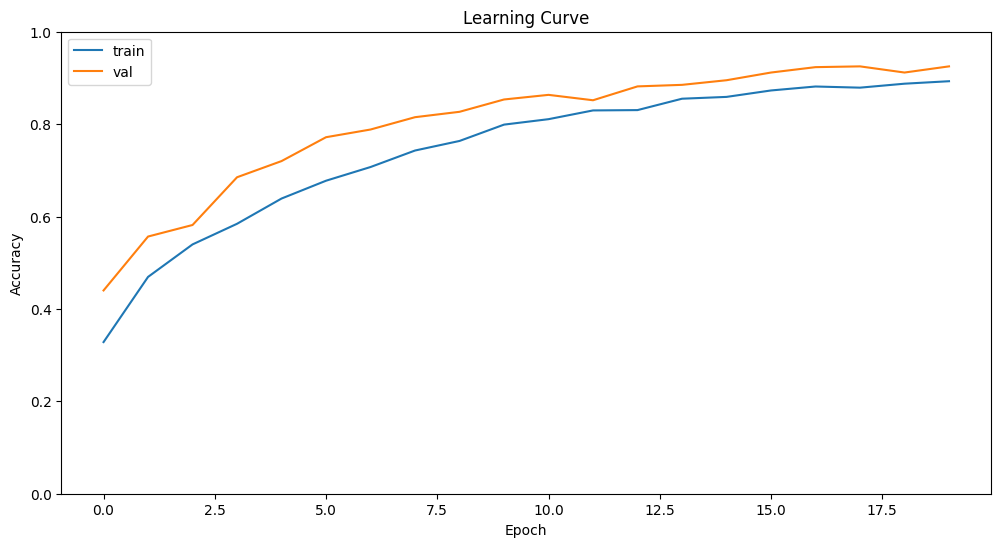

In [ ]:
learning_curve(inc_hist,'loss', ylim=(0,1))
learning_curve(inc_hist, 'accuracy', ylim=(0,1))

Train: 0.937, Test: 0.927, Val: 0.925
Test Cohens kappa: 0.902125


[[131   4   4   6]
 [ 11 125   8   0]
 [  2   0 151   4]
 [  3   1   1 149]]


F1 Score: 0.9263609574260658


              precision    recall  f1-score   support

 NDeficiency       0.89      0.90      0.90       145
 KDeficiency       0.96      0.87      0.91       144
     Healthy       0.92      0.96      0.94       157
 PDeficiency       0.94      0.97      0.95       154

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



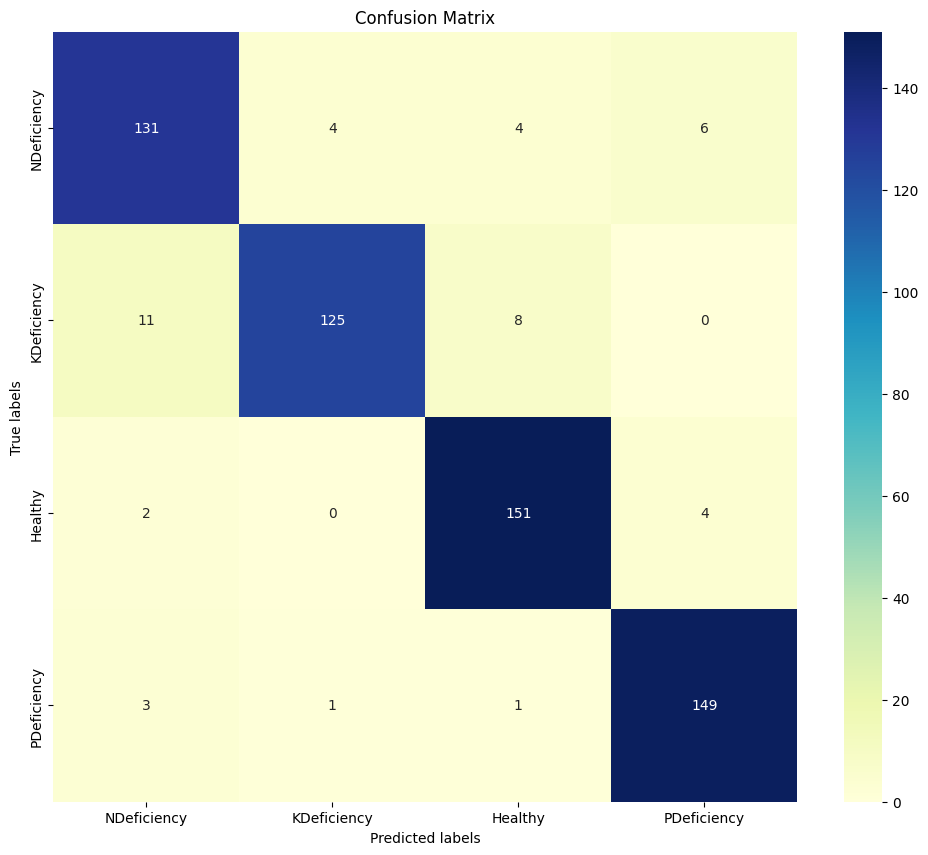

In [ ]:
cal_score(inc_model9, 1)